# Using DASK to parallelize

In [1]:
from dask.distributed import LocalCluster, Client

# if you are copy pasting this from the book, make sure 
# the address is the same that the instructor gave in the lesson!
address = 'tcp://127.0.0.1:34217'
client = Client(address)
client

<Client: 'tcp://127.0.0.1:34217' processes=70 threads=140, memory=220.10 GiB>

In [4]:
import os
import urllib
import pandas as pd

import dask.dataframe as dd

In [3]:
url = 'https://arcticdata.io/metacat/d1/mn/v2/object/urn%3Auuid%3A27e4043d-75eb-4c4f-9427-0d442526c154'

msg = urllib.request.urlretrieve(url, "dg_soil_moisture.csv")

In [5]:
fp = os.path.join(os.getcwd(),'dg_soil_moisture.csv')
df = dd.read_csv(fp, blocksize = '20MB' , encoding='ISO-8859-1')
df

,timestamp,year,doy,hour,minute,site,logger,port,sensor,sensorZ,m_soil,unit
npartitions=6,,,,,,,,,,,,
,string,int64,int64,int64,int64,string,string,string,string,int64,float64,string
,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...


In [6]:
df.head(3)

,timestamp,year,doy,hour,minute,site,logger,port,sensor,sensorZ,m_soil,unit
0,2014-07-07 16:30:00,2014,188,16,30,MDF1,MDF1met,Port 3,5TM Moisture/Temp,-6,0.273,m³/m³ VWC
1,2014-07-07 16:30:00,2014,188,16,30,MDF1,MDF1met,Port 4,5TM Moisture/Temp,-11,0.345,m³/m³ VWC
2,2014-07-07 17:00:00,2014,188,17,0,LDF2,LDF2met,Port 3,5TM Moisture/Temp,-8,0.308,m³/m³ VWC


In [7]:
type(df.head())

pandas.core.frame.DataFrame

In [8]:
type(df)

dask.dataframe.dask_expr._collection.DataFrame

In [9]:
averages = df.groupby('year').mean(numeric_only = True)
averages

,doy,hour,minute,sensorZ,m_soil
npartitions=1,,,,,
,float64,float64,float64,float64,float64
,...,...,...,...,...


In [10]:
averages.compute()

,doy,hour,minute,sensorZ,m_soil
year,,,,,
2014,276.852636,11.513992,15.001123,-11.998332,0.273744
2015,186.720383,11.500723,15.000000,-13.047899,0.263738
2016,183.497453,11.499777,14.999858,-15.000009,0.293595
2017,181.414843,11.499381,15.000144,-14.999981,0.266121
2018,201.824077,11.500796,15.000356,-15.435365,0.282395
2019,173.693311,11.498577,15.000000,-15.124516,0.222193
2020,138.806679,11.489825,14.999322,-15.200054,0.252467


# Dask Arrays

In [11]:
import numpy as np

import dask.array as da

In [12]:
data = np.arange(100_000).reshape(200,500)
data

array([[    0,     1,     2, ...,   497,   498,   499],
       [  500,   501,   502, ...,   997,   998,   999],
       [ 1000,  1001,  1002, ...,  1497,  1498,  1499],
       ...,
       [98500, 98501, 98502, ..., 98997, 98998, 98999],
       [99000, 99001, 99002, ..., 99497, 99498, 99499],
       [99500, 99501, 99502, ..., 99997, 99998, 99999]], shape=(200, 500))

In [13]:
a = da.from_array(data, chunks = (100,100))
a

dask.array<array, shape=(200, 500), dtype=int64, chunksize=(100, 100), chunktype=numpy.ndarray>

In [14]:
a.mean

<bound method Array.mean of dask.array<array, shape=(200, 500), dtype=int64, chunksize=(100, 100), chunktype=numpy.ndarray>>

In [15]:
a.mean().compute()

np.float64(49999.5)

In [16]:
# download red band
url = 'https://arcticdata.io/metacat/d1/mn/v2/object/urn%3Auuid%3Aac25a399-b174-41c1-b6d3-09974b161e5a'
msg = urllib.request.urlretrieve(url, "RU_ANS_TR2_FL005M_red.tif")


# download nir band
url = 'https://arcticdata.io/metacat/d1/mn/v2/object/urn%3Auuid%3A1762205e-c505-450d-90ed-d4f3e4c302a7'
msg = urllib.request.urlretrieve(url, "RU_ANS_TR2_FL005M_nir.tif")

In [17]:
import rioxarray as rioxr

In [19]:
red = rioxr.open_rasterio('RU_ANS_TR2_FL005M_red.tif', chunks = '15MB')
red

<xarray.DataArray (band: 1, y: 3499, x: 7443)> Size: 104MB
dask.array<open_rasterio-496028087e7402e65f278d89c0f88633<this-array>, shape=(1, 3499, 7443), dtype=float32, chunksize=(1, 1936, 1936), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 60kB 6.22e+05 6.22e+05 ... 6.224e+05 6.224e+05
  * y            (y) float64 28kB 7.525e+06 7.525e+06 ... 7.525e+06 7.525e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_SOFTWARE:  pix4dmapper
    AREA_OR_POINT:     Area
    _FillValue:        -10000.0
    scale_factor:      1.0
    add_offset:        0.0

In [20]:
red.squeeze()

<xarray.DataArray (y: 3499, x: 7443)> Size: 104MB
dask.array<getitem, shape=(3499, 7443), dtype=float32, chunksize=(1936, 1936), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
  * x            (x) float64 60kB 6.22e+05 6.22e+05 ... 6.224e+05 6.224e+05
  * y            (y) float64 28kB 7.525e+06 7.525e+06 ... 7.525e+06 7.525e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_SOFTWARE:  pix4dmapper
    AREA_OR_POINT:     Area
    _FillValue:        -10000.0
    scale_factor:      1.0
    add_offset:        0.0

In [21]:
nir = rioxr.open_rasterio('RU_ANS_TR2_FL005M_nir.tif', chunks = '15MB')
nir

<xarray.DataArray (band: 1, y: 3499, x: 7443)> Size: 104MB
dask.array<open_rasterio-f001247ce012a68bdd76789df0dac2ce<this-array>, shape=(1, 3499, 7443), dtype=float32, chunksize=(1, 1936, 1936), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 60kB 6.22e+05 6.22e+05 ... 6.224e+05 6.224e+05
  * y            (y) float64 28kB 7.525e+06 7.525e+06 ... 7.525e+06 7.525e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_SOFTWARE:  pix4dmapper
    AREA_OR_POINT:     Area
    _FillValue:        -10000.0
    scale_factor:      1.0
    add_offset:        0.0

In [24]:
nir = nir.squeeze()
red = red.squeeze()

ndvi = (nir-red)/(nir+red)
ndvi

<xarray.DataArray (y: 3499, x: 7443)> Size: 104MB
dask.array<truediv, shape=(3499, 7443), dtype=float32, chunksize=(1936, 1936), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
  * x            (x) float64 60kB 6.22e+05 6.22e+05 ... 6.224e+05 6.224e+05
  * y            (y) float64 28kB 7.525e+06 7.525e+06 ... 7.525e+06 7.525e+06
    spatial_ref  int64 8B 0

In [25]:
ndvi_values = ndvi.compute()

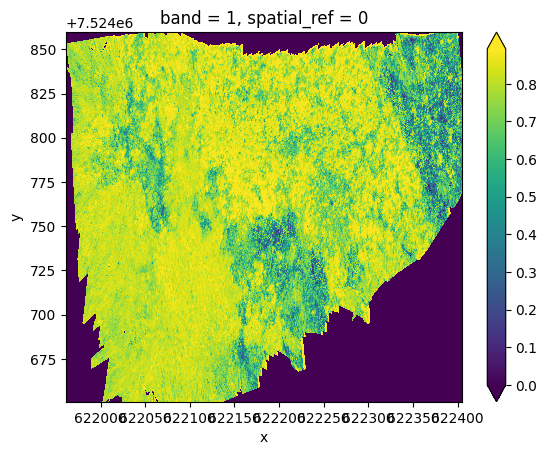

In [26]:
ndvi_values.plot(robust=True)